In [2]:
import pandas as pd
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib
import lightgbm as lgb
import numpy as np
print("everything import well")

everything import well


In [3]:
import nltk

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


In [4]:
import re
import nltk
from nltk.corpus import stopwords

# Ensure stopwords are available
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# English stopwords
english_stopwords = set(stopwords.words('english'))

#Somali stopwords (custom – can be expanded carefully)
somali_stopwords = {
    "iyo", "waa", "in", "ka", "ku", "si", "ayaa", "ma", "haa", "leh", "loo",
    "la", "u", "wax", "badan", "ahay", "karo", "mid", "kuma", "wuu", "waxa"
}

# Combine stopwords
all_stopwords = english_stopwords.union(somali_stopwords)

def clean_text(text):
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # 3. Tokenize (simple split)
    words = text.split()
    
    # 4. Remove English + Somali stopwords
    words = [word for word in words if word not in all_stopwords]
    
    # 5. Join words back to text
    return " ".join(words)




In [5]:
df = pd.read_csv("extended_spam_dataset.csv")
df.columns = ["label", "message"]                       # ensure correct format
df = df[df["label"].isin(["ham", "spam"])]             # keep only valid labels


In [6]:
df['clean_message'] = df['message'].apply(clean_text)
df[['message', 'clean_message']].head()


,message,clean_message
0,22 days to kick off! For Euro2004 U will be ke...,days kick euro kept date latest news results d...
1,Dai what this da.. Can i send my resume to thi...,dai da send resume id
2,Al he does is moan at me if n e thin goes wron...,al moan n e thin goes wrong faultal de argumen...
3,Maanta waan mashquulsanahay.,maanta waan mashquulsanahay
4,I'm in class. Will holla later,im class holla later


In [7]:
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df['label'].value_counts()


label
0    5325
1    1247
Name: count, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

X = df['clean_message']   # use consistent column name
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [9]:
print("Train distribution:")
print(y_train.value_counts())

print("\nTest distribution:")
print(y_test.value_counts())


Train distribution:
label
0    4260
1     997
Name: count, dtype: int64

Test distribution:
label
0    1065
1     250
Name: count, dtype: int64


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_features=6000
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(X_train_vec.shape)
print(X_test_vec.shape)


(5257, 6000)
(1315, 6000)


In [11]:
# ==============================
# 6A. TRAIN SVM MODEL
# ==============================
svm_model = SVC(
    kernel="linear",
    probability=True,
    class_weight="balanced",
    C=2
)


svm_model.fit(X_train_vec, y_train)


svm_pred = svm_model.predict(X_test_vec)

print("\n=== SVM Accuracy ===")
print(accuracy_score(y_test, svm_pred))

print("\n=== SVM Report ===")
print(classification_report(y_test, svm_pred))



=== SVM Accuracy ===
0.9863117870722433

=== SVM Report ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1065
           1       0.97      0.96      0.96       250

    accuracy                           0.99      1315
   macro avg       0.98      0.98      0.98      1315
weighted avg       0.99      0.99      0.99      1315



In [12]:
# ==============================
# 6B. TRAIN LIGHTGBM MODEL (CORRECT)
# ==============================
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# LightGBM datasets (labels already numeric)
lgb_train = lgb.Dataset(X_train_vec, label=y_train)
lgb_eval = lgb.Dataset(X_test_vec, label=y_test, reference=lgb_train)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 40,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1
}

lightgbm_model = lgb.train(
    params,
    lgb_train,
    num_boost_round=300,
    valid_sets=[lgb_eval],
    callbacks=[lgb.early_stopping(stopping_rounds=30)]
)

# Predictions
lgb_pred_prob = lightgbm_model.predict(X_test_vec)
lgb_pred = (lgb_pred_prob >= 0.5).astype(int)

print("\n=== LightGBM Accuracy ===")
print(accuracy_score(y_test, lgb_pred))

print("\n=== LightGBM Report ===")
print(classification_report(y_test, lgb_pred))


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.0773083

=== LightGBM Accuracy ===
0.9787072243346008

=== LightGBM Report ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1065
           1       0.95      0.94      0.94       250

    accuracy                           0.98      1315
   macro avg       0.97      0.96      0.97      1315
weighted avg       0.98      0.98      0.98      1315



In [17]:
# ==============================
# 7. SAVE MODELS
# ==============================
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(lightgbm_model, "lightgbm_model.pkl")

print("\nModels saved successfully!")


Models saved successfully!


In [27]:
# ==============================
# 1. IMPORT LIBRARIES
# ==============================
import re
import joblib
import nltk
from nltk.corpus import stopwords
import numpy as np

# ==============================
# 2. ENSURE STOPWORDS
# ==============================
try:
    nltk.data.find("corpora/stopwords")
except LookupError:
    nltk.download("stopwords")

# ==============================
# 3. STOPWORDS (ENGLISH + SOMALI)
# ==============================
english_stopwords = set(stopwords.words("english"))

somali_stopwords = {
    "iyo", "waa", "in", "ka", "ku", "si", "ayaa", "ma", "haa", "leh", "loo",
    "la", "u", "wax", "badan", "ahay", "karo", "mid", "kuma", "wuu", "waxa"
}

all_stopwords = english_stopwords.union(somali_stopwords)

# ==============================
# 4. CLEAN TEXT FUNCTION
# ==============================
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    words = text.split()
    words = [w for w in words if w not in all_stopwords]
    return " ".join(words)

# ==============================
# 5. LOAD MODELS & VECTORIZER
# ==============================
svm_model = joblib.load("svm_model.pkl")
lgbm_model = joblib.load("lightgbm_model.pkl")  # LightGBM Booster
vectorizer = joblib.load("vectorizer.pkl")

print("✅ Models and vectorizer loaded successfully")

# ==============================
# 6. TEST MESSAGE
# ==============================
test_message = (
    "Click this link and get free money or reward"
)

# Clean & vectorize
cleaned_message = clean_text(test_message)
message_vec = vectorizer.transform([cleaned_message])

# ==============================
# 7. SVM PREDICTION
# ==============================
svm_pred = svm_model.predict(message_vec)[0]
svm_probs = svm_model.predict_proba(message_vec)[0]

svm_ham_prob = svm_probs[0]
svm_spam_prob = svm_probs[1]

# ==============================
# 8. LIGHTGBM BOOSTER PREDICTION
# ==============================
# Booster.predict() returns probability
lgbm_spam_prob = lgbm_model.predict(message_vec)[0]
lgbm_ham_prob = 1 - lgbm_spam_prob

lgbm_pred = 1 if lgbm_spam_prob >= 0.5 else 0

# ==============================
# 9. OUTPUT RESULTS
# ==============================
print("\n==============================")
print("📩 ORIGINAL MESSAGE:")
print(test_message)

print("\n🧹 CLEANED MESSAGE:")
print(cleaned_message)

print("\n==============================")
print("📊 MODEL COMPARISON\n")

print("🔹 SVM MODEL:")
if svm_pred == 1:
    print(f"🚨 SPAM | Confidence: {svm_spam_prob:.2f}")
else:
    print(f"✅ HAM  | Confidence: {svm_ham_prob:.2f}")

print("\n🔹 LIGHTGBM MODEL:")
if lgbm_pred == 1:
    print(f"🚨 SPAM | Confidence: {lgbm_spam_prob:.2f}")
else:
    print(f"✅ HAM  | Confidence: {lgbm_ham_prob:.2f}")

# ==============================
# 10. ENSEMBLE (OPTIONAL BONUS)
# ==============================
ensemble_spam_prob = (svm_spam_prob + lgbm_spam_prob) / 2
ensemble_pred = 1 if ensemble_spam_prob >= 0.5 else 0

print("\n🔹 ENSEMBLE (SVM + LightGBM):")
if ensemble_pred == 1:
    print(f"🚨 SPAM | Confidence: {ensemble_spam_prob:.2f}")
else:
    print(f"✅ HAM  | Confidence: {1 - ensemble_spam_prob:.2f}")

print("\n==============================")


✅ Models and vectorizer loaded successfully

📩 ORIGINAL MESSAGE:
Click this link and get free money or reward

🧹 CLEANED MESSAGE:
click link get free money reward

📊 MODEL COMPARISON

🔹 SVM MODEL:
🚨 SPAM | Confidence: 0.99

🔹 LIGHTGBM MODEL:
🚨 SPAM | Confidence: 0.71

🔹 ENSEMBLE (SVM + LightGBM):
🚨 SPAM | Confidence: 0.85



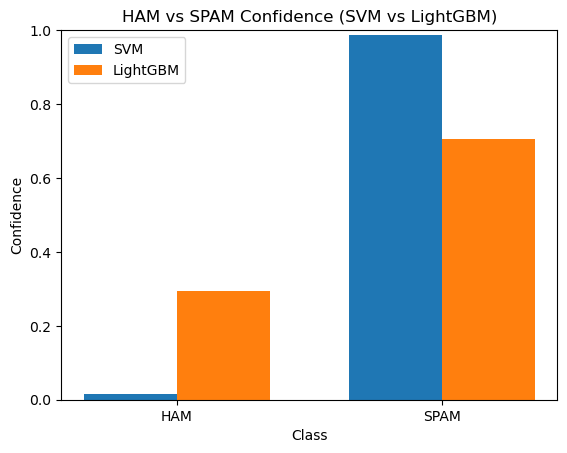

In [29]:
import numpy as np
import matplotlib.pyplot as plt

labels = ["HAM", "SPAM"]

svm_scores = [svm_ham_prob, svm_spam_prob]
lgbm_scores = [lgbm_ham_prob, lgbm_spam_prob]

x = np.arange(len(labels))
width = 0.35

plt.figure()
plt.bar(x - width/2, svm_scores, width, label="SVM")
plt.bar(x + width/2, lgbm_scores, width, label="LightGBM")

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.xlabel("Class")
plt.ylabel("Confidence")
plt.title("HAM vs SPAM Confidence (SVM vs LightGBM)")
plt.legend()
plt.show()


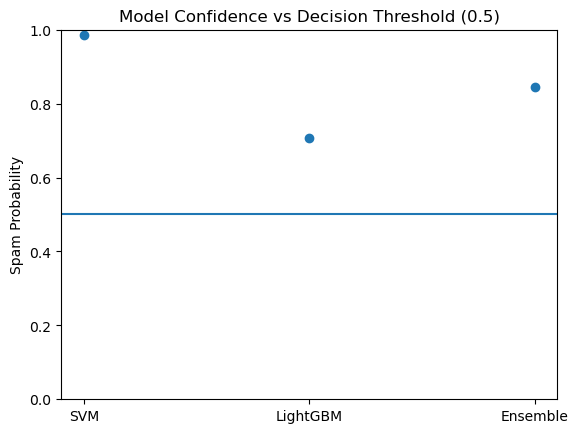

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.axhline(y=0.5)
plt.scatter(["SVM", "LightGBM", "Ensemble"],
            [svm_spam_prob, lgbm_spam_prob, ensemble_spam_prob])
plt.ylim(0, 1)
plt.ylabel("Spam Probability")
plt.title("Model Confidence vs Decision Threshold (0.5)")
plt.show()


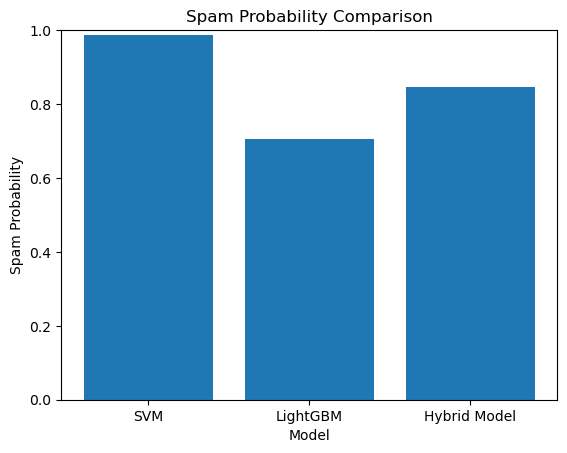

In [31]:
import matplotlib.pyplot as plt

models = ["SVM", "LightGBM", "Hybrid Model"]
spam_probs = [svm_spam_prob, lgbm_spam_prob, ensemble_spam_prob]

plt.figure()
plt.bar(models, spam_probs)
plt.ylim(0, 1)
plt.xlabel("Model")
plt.ylabel("Spam Probability")
plt.title("Spam Probability Comparison")

# Save chart
plt.savefig("spam_probability_comparison.png", dpi=300, bbox_inches="tight")
plt.show()


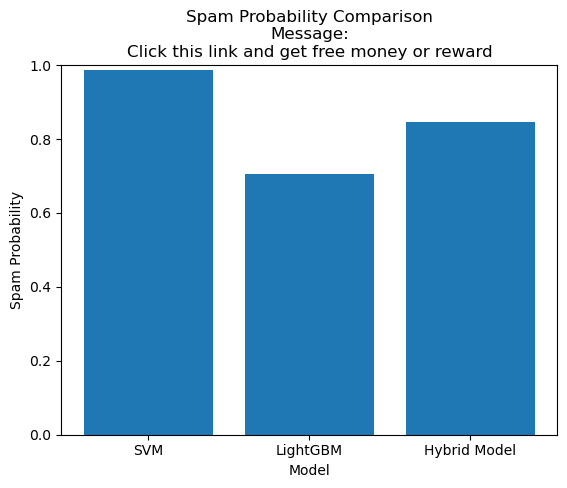

In [32]:
import matplotlib.pyplot as plt
import textwrap

models = ["SVM", "LightGBM", "Hybrid Model"]
spam_probs = [svm_spam_prob, lgbm_spam_prob, ensemble_spam_prob]

# Wrap long message for readability
wrapped_message = "\n".join(textwrap.wrap(test_message, 60))

plt.figure()
plt.bar(models, spam_probs)
plt.ylim(0, 1)
plt.xlabel("Model")
plt.ylabel("Spam Probability")

plt.title(f"Spam Probability Comparison\nMessage:\n{wrapped_message}")

plt.savefig("spam_probability_comparison.png", dpi=300, bbox_inches="tight")
plt.show()
